# 🐶 Using Transfer Learning and TensorFlow 2.x to Classify Different Dog Breeds

## Who's that doggy in the window?

Dogs are incredible. But have you ever been sitting at a cafe, seen a dog and not known what breed it is? I have. And then someone says, "it's an English Terrier" and you think, how did they know that?

In this project, we're going to be using machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the Kaggle dog breed identification competition. It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify multiple different breeds of dogs. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in automatically adding information to their listings.

Since the most important step in a deep learning problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:

1. **Get data ready** (download from Kaggle, store, import).
2. **Prepare the data** (preprocessing, the 3 sets, X & y).
3. **Choose and fit/train a model** (TensorFlow Hub, `tf.keras.applications`, TensorBoard, EarlyStopping).
4. **Evaluate the model** (making predictions, comparing them with the ground truth labels).
5. **Improve the model through experimentation** (start with 1000 images, make sure it works, increase the number of images).
6. **Save, share, and reload your model** (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called **transfer learning**. We do this because rather than train our own model from scratch (which could be time-consuming and expensive), we leverage the patterns of another model which has been trained to classify images.

## Getting our workspace ready

Before we get started, since we'll be using TensorFlow 2.x and TensorFlow Hub, let's import them.

> **NOTE**: Don't run the cell below if you're already using TF 2.x.


In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.10.0
Hub version: 0.8.0
GPU not available :(


## What is a GPU and Why Do We Need One?

---

You might be wondering what a GPU is or why we need one. The short story is, a GPU (Graphics Processing Unit) is a computer chip designed for high-speed numerical computing. Since machine learning is all about finding patterns in numbers, that's where GPUs come into play.

## Checking GPU Availability in Google Colab

When you run your code for the first time in Google Colab, you might find that there is no GPU available. This is because, by default, Colab runs on a computer located on Google's servers that doesn't have a GPU attached to it.

To enable a GPU, follow these steps:

1. **Go to Runtime** in the top menu.
2. **Click "Change runtime type"**.
3. **Where it says "Hardware accelerator"**, choose **"GPU"** (don't worry about TPU for now, but feel free to research them).
4. **Click Save**.
5. The runtime will be restarted to activate the new hardware, so you'll need to rerun the above cells.
6. If the steps have worked, you should see a printout saying **"GPU available"**.

If you want an example of how much a GPU speeds up computing, [Google Colab has a demonstration notebook available](https://colab.research.google.com/notebooks/gpu_demo.ipynb).

## Getting Data Ready

Since much of machine learning involves preparing your data for use with a machine learning model, we’ll take extra care to get it set up.

There are a few ways to get your data ready. Many of these methods are detailed in the [Google Colab notebook on I/O (Input and Output)](https://colab.research.google.com/notebooks/io.ipynb).

Because the data we’re using is hosted on Kaggle, you can use the Kaggle API to access it. 

But what if the data you want to use isn’t on Kaggle?

One alternative is to upload the data to your Google Drive, mount your drive in this notebook, and import the file. 



## Accessing the Data

Now that the data files we're working with are available on our Google Drive, we can start to check them out.

Let’s begin with `labels.csv`, which contains all of the image IDs and their associated dog breeds (our data and labels).


In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("./data/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [3]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
# How many images are there of each breed?
labels_csv["breed"].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

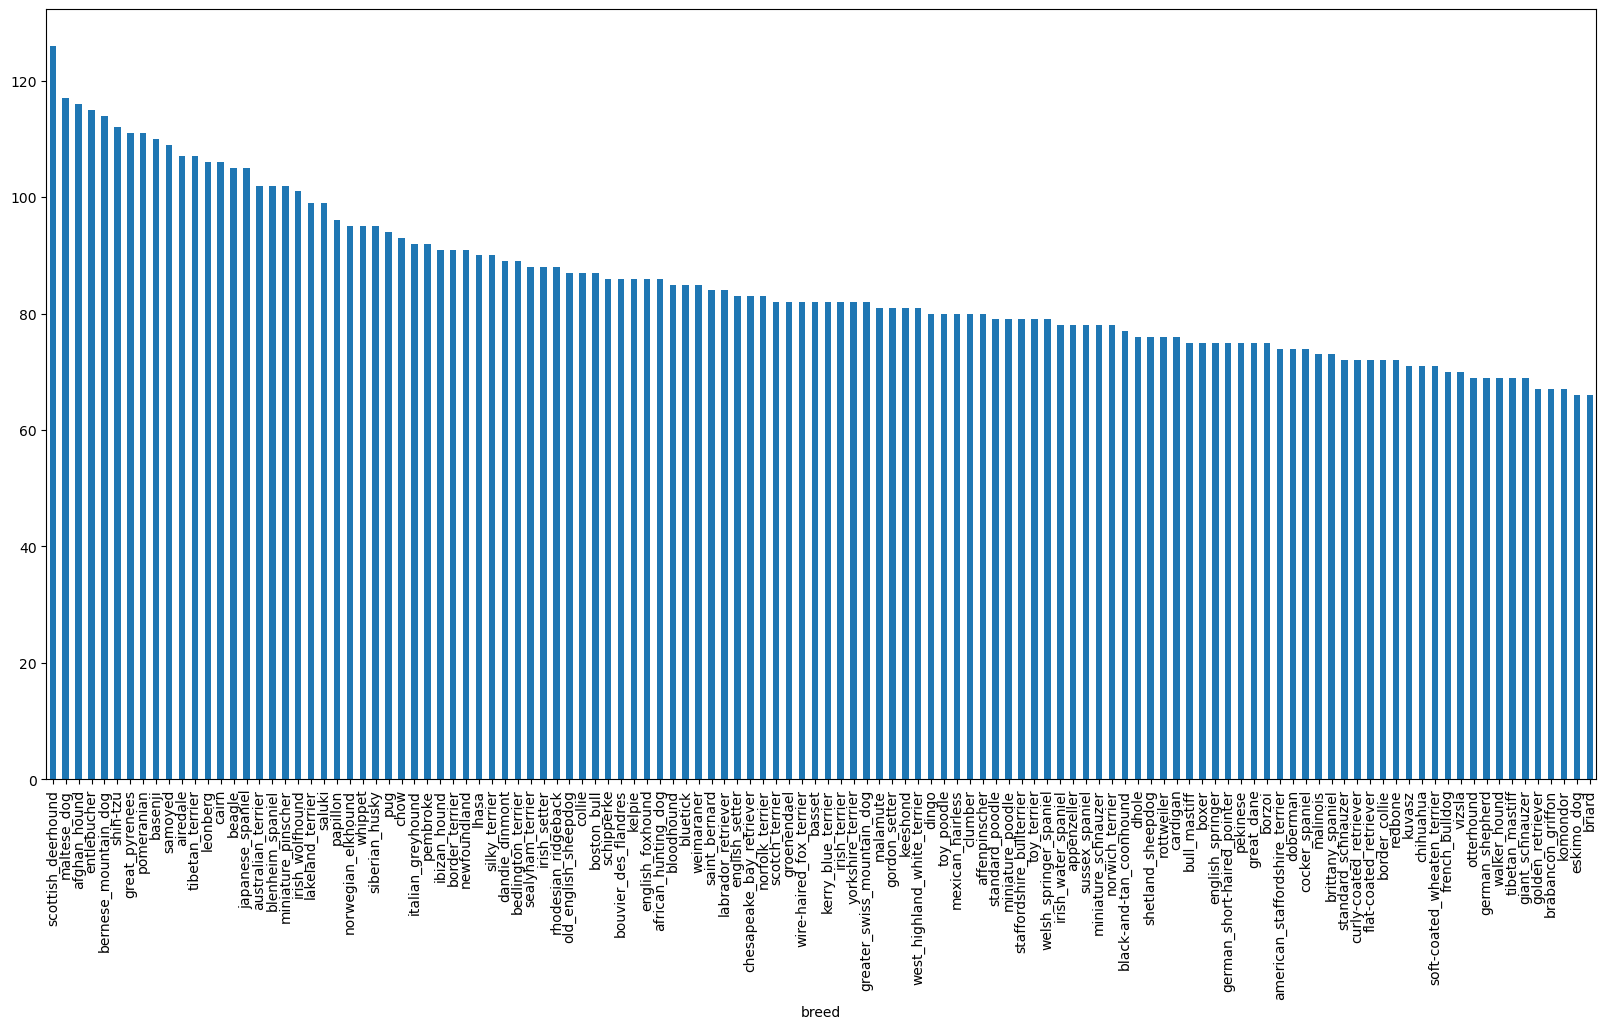

In [5]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [6]:
labels_csv["breed"].value_counts().median()

82.0

In [7]:
from IPython.display import display, Image

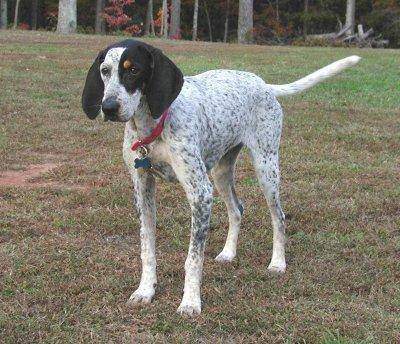

In [8]:
Image('./data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg')

## Getting images and their labels

Since we've got the image IDs and their labels in a DataFrame (`labels_csv`), we'll use it to create:

- A list of filepaths to training images
- An array of all labels
- An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much more efficient than working with images.


In [9]:
# Create pathnames from image ID's
filenames = [ './data/train/'+ fname + '.jpg' for fname in labels_csv['id'] ]
# check the first  10 
filenames[:10]

['./data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 './data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 './data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

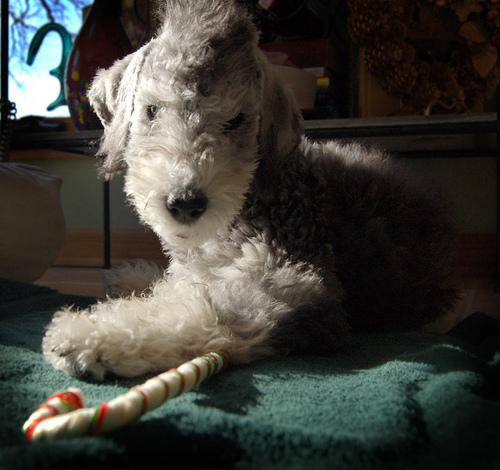

In [10]:
Image('./data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg')

Now we've got a list of all the filenames from the `ID` column of `labels_csv`, we can compare it to the number of files in our training data directory to see if they line up.

If they do, great. If not, there may have been an issue when unzipping the data (what we did above). To fix this, you might have to unzip the data again. Be careful not to let your Colab notebook disconnect whilst unzipping.


In [11]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("./data/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


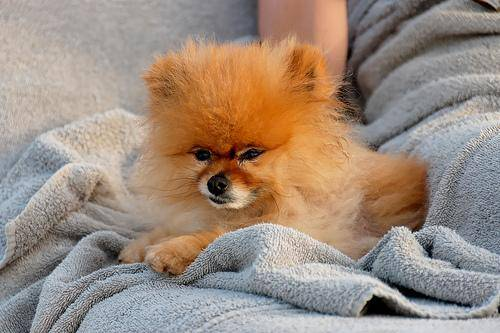

In [12]:
# Check an image directly from a filepath
Image(filenames[8000])

In [13]:
labels_csv['breed'][8000]

'pomeranian'

In [14]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [15]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames 😎🦾 ")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames 😎🦾 


If it all worked, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what labels currently are), we'll have to convert our labels to numbers.

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of labels, compare them to unique breeds, and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).


In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds[:20]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull'], dtype=object)

In [17]:
len(unique_breeds)

120

The length of `unique_breeds` should be 120, meaning we're working with images of 120 different breeds of dogs.

Now, use `unique_breeds` to help turn our labels array into an array of booleans.


In [18]:
# Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels ]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
#  Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predictions on the test set), let's make one.

We could use Scikit-Learn's `train_test_split` function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to `X` (data) and our labels to `y`.


In [22]:
# Setup X & y variables
X = filenames
y = boolean_labels

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 1000 and increase it as we need.


In [23]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

In [24]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train , X_val , y_train , y_val = train_test_split( X[:NUM_IMAGES] ,
                                                      y[:NUM_IMAGES],
                                                      test_size=0.2 ,
                                                       random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [25]:
# Check out the training data (image file paths and labels)
X_train[:2] , y_train[:2]

(['./data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  './data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, Fa

Preprocessing images (turning images into Tensors)
=============================================

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.
A Tensor is a way to represent information in numbers. If you're familiar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.
Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:

* Takes an image filename as input.
* Uses TensorFlow to read the file and save it to a variable, `image`.
* Turn our image (a jpeg file) into Tensors.
* Resize the image to be of shape `(224, 224)`.
* Return the modified image.
A good place to read about this type of function is the TensorFlow documentation on loading images.

You might be wondering why `(224, 224)`, which is (height, width). It's because this is the size of input our model (we'll see this soon) takes, an image which is `(224, 224, 3)`.

What? Where's the `3` from? We're getting ahead of ourselves but that's the number of colour channels per pixel, red, green and blue.

Let's make this a little more concrete.

In [26]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

Notice the shape of image. It's `(257, 350, 3)`. This is height, width, colour channel value.

And you can easily convert it to a Tensor using `tf.constant()`.

In [27]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [28]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image
    

Creating data batches
=====================

Wonderful. Now we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow BatchDataset).

What's a batch?
----------------

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of our `process_image` function at the same time.

In [29]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [30]:
# Demo 
(process_image(X[42]) , tf.constant(y[42]) )

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now that we have a function to convert our image file paths and labels into tuples, we can move on to creating data batches. To accommodate the three distinct sets of data - training, validation, and testing - we'll design a function that can handle each set individually.

As a nod to the wisdom of Yann Lecun, a pioneer in the field of deep learning, we'll set a default batch size of 32. This size has been widely accepted as a sweet spot for training models, and we'll use it as our starting point.

In [36]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X , y=None , batch_size=BATCH_SIZE , valid_data=False , test_data=False ):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
    Also accepts test data as input (no labels)
    """
    # if the data is a test dataset !! probably we dont have labels 
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only files 
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
        # If the data if a valid dataset, we don't need to shuffle it
    elif valid_data:
        print('Creating Validation data Batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else:
        print('creating training data batches ...')
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                  tf.constant(y))) # labels
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))
        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)
        # Turn the data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch
        

In [37]:
# Create training and validation data batches
train_data = create_data_batches(X_train , y_train)
val_data = create_data_batches(X_val , y_val , valid_data=True)

creating training data batches ...
Creating Validation data Batches...


In [39]:
# Check out the different attributes of our data batches
train_data.element_spec , val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))